In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

## Load Dataset

In [375]:
#load preprocessed dataset
data = pd.read_csv('../data/processed_text.csv')
data.head()

,post_id,title,created_utc,subreddit,comments,title_length,processed_title,processed_comments,processed_text,comments_length
0,1fzfb8t,Will Trump or Kamala Harris win key swing stat...,2024-10-09 00:45:16,technology,['I asked AI how to clean a cast iron pan and ...,72,trump kamala harris win key swing state ask ch...,ask ai clean cast iron pan tell mix bleach amm...,trump kamala harris win key swing state ask ch...,85
1,1fyxmo4,Nobel Prize in physics awarded to 2 scientists...,2024-10-08 11:37:11,technology,[],99,nobel prize physics award scientist discovery ...,NaN,nobel prize physics award scientist discovery ...,2
2,1fz0m72,Adobe has a new tool to protect artists’ work ...,2024-10-08 14:05:54,technology,"['The irony... Adobe stole from, pardon ""opted...",53,adobe new tool protect artist work ai,irony adobe steal pardon opt creative datum gr...,adobe new tool protect artist work ai irony ad...,560
3,1fc2c3m,Stellantis And Tesla Hit Rock Bottom In CR’s U...,2024-09-08 16:50:16,technology,['How can Stellantis (Chrysler/Jeep/Ram) hit r...,80,stellantis tesla hit rock crs car brand reliab...,stellantis chryslerjeepram hit rock rock delete,stellantis tesla hit rock crs car brand reliab...,105
4,1fc2ufg,Analysis of thousands of channels reveals Tele...,2024-09-08 17:12:16,technology,"['Funny part, these days Telegram is the only ...",85,analysis thousand channel reveal telegram floo...,funny day telegram widely message platform end...,analysis thousand channel reveal telegram floo...,270


### Model Preparation

In [377]:
# Define X and y.

X = data['processed_text']
y = data['subreddit']

### Baseline Accuracy

In [379]:
y.value_counts(normalize = True)#imbalanced class so we need to stratify

subreddit
technology    0.619191
gadgets       0.380809
Name: proportion, dtype: float64

### Train Test Split

In [381]:
# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


### Model 1: Logistic Regression with Count Vectorizer


In [383]:
logr_pipe = Pipeline(
    [
        ('cvec',CountVectorizer()),
        ('logr',LogisticRegression())
    ]
)

grid_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'cvec__max_df': [0.75, 0.85, 1.0],      # Ignore very frequent words
    'cvec__min_df': [1, 2, 5],              # Ignore very infrequent words
    'cvec__max_features': [None, 5000, 10000],  # Limit on the number of features

    'logr__C': [0.01, 0.1, 1.0, 10],        # Regularization strength
    'logr__penalty': ['l2'],                # L2 regularization (Ridge)
    'logr__solver': ['lbfgs', 'liblinear']  # Solvers suitable for small datasets
}


gs_logr = GridSearchCV(logr_pipe,grid_params,n_jobs=-1)
gs_logr.fit(X_train,y_train)
print(f' Best parameters:{gs_logr.best_params_}')
print(f' Best score:{gs_logr.best_score_}')

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Best parameters:{'cvec__max_df': 0.75, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'logr__C': 10, 'logr__penalty': 'l2', 'logr__solver': 'liblinear'}
 Best score:0.8466834271274504


In [384]:
###Logistic Regression Coefficients 
print(f"Logistic Regression Intercept: {gs_logr.best_estimator_.named_steps['logr'].intercept_}")
print(f"Logistic Regression Coefficients: {gs_logr.best_estimator_.named_steps['logr'].coef_}")

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
coefficients_df.head(),coefficients_df.tail(),

Logistic Regression Intercept: [0.50765203]
Logistic Regression Coefficients: [[-1.45591471e-01 -1.45638079e-01  4.66082383e-05 ... -1.90174770e-02
   1.69779253e-07  1.69779253e-07]]


(        Feature  Coefficient
 6065         ai     2.077758
 242954    tesla     1.762007
 247221   tiktok     1.666287
 37768   chatgpt     1.518641
 277141  youtube     1.484690,
              Feature  Coefficient
 188369       printer    -1.484446
 133367  life explain    -1.505162
 128948        laptop    -1.630474
 206180        review    -1.664971
 93343         gadget    -2.581317)

The logistic regression coefficients help you understand which words are driving the predictions for each class. Positive coefficients indicate that a word is associated with the positive class (e.g., "technology" in our case), while negative coefficients indicate that a word is associated with the opposite class (e.g., "gadgets").

### Model Evaluation

In [387]:
preds = gs_logr.predict(X_test)

logr_train_accuracy = round(gs_logr.score(X_train, y_train), 2)
logr_test_accuracy = round(gs_logr.score(X_test, y_test), 2)

logr_train_misclassification_rate = round(1 - train_accuracy, 2)
logr_test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of Logistic Regression with Count Vectorizer: {logr_train_accuracy}')
print(f'Testing Accuracy of Logistic Regression with Count Vectorizer: {logr_test_accuracy}')

print(f'Training Misclassification Rate: {logr_train_misclassification_rate}')
print(f'Testing Misclassification Rate: {logr_test_misclassification_rate}')
#specificity

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

logr_spec = tn / (tn + fp)
print(f'Logistic Regression specificity: {round(logr_spec,2)}')
# recall

logr_recall = tp / (tp + fn)

print(f'Logistic Regression recall: {round(logr_recall,2)}')
logr_f1_tech = f1_score(y_test, preds, pos_label='technology')
logr_f1_gad = f1_score(y_test, preds, pos_label='gadgets')

print(f'Logistic Regression F1_score Technology: {round(logr_f1_tech,2)}')
print(f'Logistic Regression F1_score gadgets : {round(logr_f1_gad,2)}')

Training Accuracy of Logistic Regression with Count Vectorizer: 1.0
Testing Accuracy of Logistic Regression with Count Vectorizer: 0.84
Training Misclassification Rate: 0.09
Testing Misclassification Rate: 0.15
Logistic Regression specificity: 0.75
Logistic Regression recall: 0.89
Logistic Regression F1_score Technology: 0.87
Logistic Regression F1_score gadgets : 0.78


In [388]:
#classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

     gadgets       0.81      0.75      0.78       791
  technology       0.85      0.89      0.87      1286

    accuracy                           0.84      2077
   macro avg       0.83      0.82      0.83      2077
weighted avg       0.84      0.84      0.84      2077



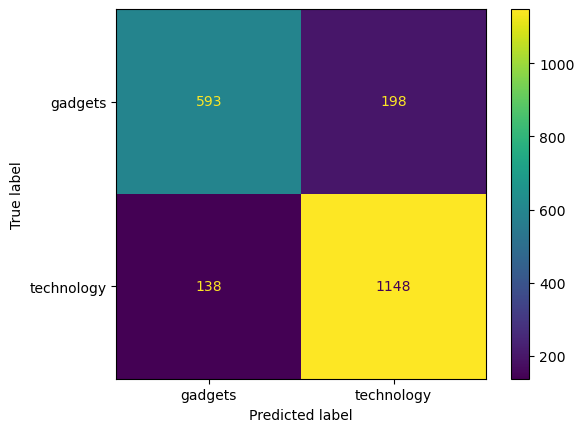

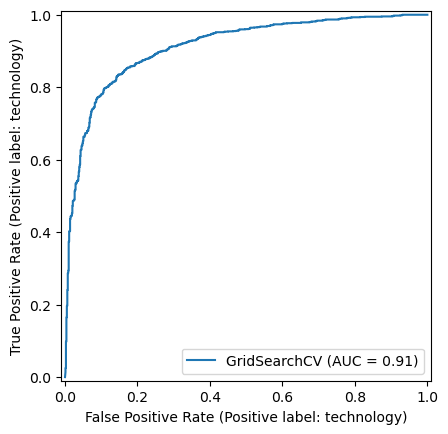

In [389]:
ConfusionMatrixDisplay.from_estimator(gs_logr,X_test,y_test);
RocCurveDisplay.from_estimator(gs_logr,X_test,y_test);

The logistic regression model performed well in classifying Reddit posts into the "technology" and "gadgets" categories, achieving an overall accuracy of 84%. The model demonstrates strong performance for identifying technology-related posts, with a precision of 85% and a recall of 89%, leading to an F1-score of 87%. This indicates that the model is highly effective in distinguishing posts about technology. However, the model’s performance on the gadgets category is slightly lower, with a precision of 81% and a recall of 75%, resulting in an F1-score of 78%. The confusion matrix shows that the model correctly classified 1,148 technology posts and 593 gadgets posts, but it misclassified 198 gadget posts as technology and 138 technology posts as gadgets. The model's ROC curve also confirms strong overall performance, with an AUC of 0.91, indicating that the model is good at distinguishing between the two categories. While the model performs better on technology posts, improving recall for gadgets could further enhance its ability to classify both categories effectively.

### Model 2:  KNN  with TF-IDF Vectorization

In [392]:
knn_pipe= Pipeline(
    [
        ('tf-idf',TfidfVectorizer()),
        ('knn',KNeighborsClassifier())
    ]
)
grid_params={
    'tf-idf__stop_words': [None, 'english'],
    'tf-idf__max_features': range(2000, 4001, 1000),
    'tf-idf__min_df': [2, 4],
    'tf-idf__max_df': np.linspace(0.9, 0.99, 5),
    'knn__n_neighbors': range(3, 12, 2)
}
gs_knn = GridSearchCV(knn_pipe,grid_params,n_jobs=-1)
gs_knn.fit(X_train,y_train)
print(f' Best parameters:{gs_knn.best_params_}')
print(f' Best score:{gs_knn.best_score_}')

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Best parameters:{'knn__n_neighbors': 11, 'tf-idf__max_df': 0.9, 'tf-idf__max_features': 4000, 'tf-idf__min_df': 4, 'tf-idf__stop_words': 'english'}
 Best score:0.8392991548859967


/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Model Evaluation

In [394]:
pred_knn = gs_knn.predict(X_test)

knn_train_accuracy = round(gs_knn.score(X_train, y_train), 2)
knn_test_accuracy = round(gs_knn.score(X_test, y_test), 2)

knn_train_misclassification_rate = round(1 - train_accuracy, 2)
knn_test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of KNN  with TF-IDF Vectorizer: {knn_train_accuracy}')
print(f'Testing Accuracy of KNN with TF-IDF Vectorizer: {knn_test_accuracy}')

print(f'Training Misclassification Rate: {knn_train_misclassification_rate}')
print(f'Testing Misclassification Rate: {knn_test_misclassification_rate}')

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred_knn).ravel()

knn_spec = tn / (tn + fp)
print(f'KNN specificity: {round(knn_spec,2)}')
# recall

knn_recall = tp / (tp + fn)

print(f'KNN recall: {round(knn_recall,2)}')
knn_f1_tech = f1_score(y_test, pred_knn, pos_label='technology')
knn_f1_gad = f1_score(y_test, pred_knn, pos_label='gadgets')

print(f'KNN F1_score Technology: {round(knn_f1_tech,2)}')
print(f'KNN F1_score gadgets : {round(knn_f1_gad,2)}')

Training Accuracy of KNN  with TF-IDF Vectorizer: 0.88
Testing Accuracy of KNN with TF-IDF Vectorizer: 0.84
Training Misclassification Rate: 0.09
Testing Misclassification Rate: 0.15
KNN specificity: 0.83
KNN recall: 0.85
KNN F1_score Technology: 0.87
KNN F1_score gadgets : 0.8


In [395]:
#classification report
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

     gadgets       0.83      0.77      0.80       791
  technology       0.86      0.91      0.88      1286

    accuracy                           0.85      2077
   macro avg       0.85      0.84      0.84      2077
weighted avg       0.85      0.85      0.85      2077



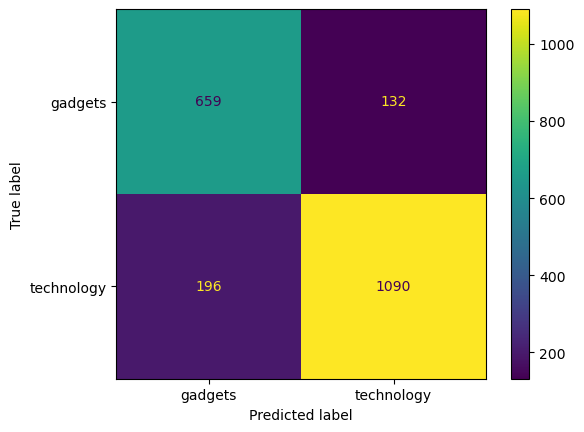

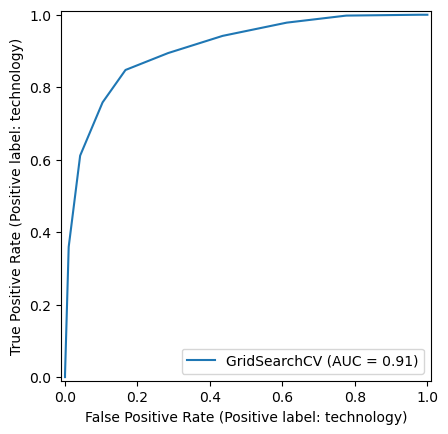

In [396]:
ConfusionMatrixDisplay.from_estimator(gs_knn,X_test,y_test);
RocCurveDisplay.from_estimator(gs_knn,X_test,y_test);

The K-Nearest Neighbors (KNN) model achieved an overall accuracy of 85%, performing well at classifying "technology" posts with a precision of 86% and recall of 91%, resulting in a strong F1-score of 0.88. However, its performance on the "gadgets" category was slightly lower, with a precision of 83% and recall of 77%, leading to an F1-score of 0.80. The confusion matrix reveals that the model correctly classified 659 gadget posts but misclassified 132 as technology, while 1,090 technology posts were correctly identified, and 196 were incorrectly classified as gadgets. The ROC curve for the model, with an AUC of 0.91, indicates that KNN has a strong ability to distinguish between the two classes.

### Model 3: Naive Bayes with TF-IDF vectors

In [399]:
pipe_nb =Pipeline(
    [
        ('tf-idf',TfidfVectorizer()),
        ('nb',MultinomialNB())
    ]
)


grid_params = {
    'tf-idf__stop_words': [None, 'english'],
    'tf-idf__max_features': range(2000, 4001, 1000),
    'tf-idf__min_df': [2, 4],
    'tf-idf__max_df': np.linspace(0.9, 0.99, 5),
    'nb__alpha': [0.1, 0.5, 1.0]            # Smoothing parameter for Naive Bayes
}

gs_nb = GridSearchCV(pipe_nb, grid_params, n_jobs=-1, cv=5)
gs_nb.fit(X_train, y_train)

print(f' Best parameters:{gs_nb.best_params_}')
print(f' Best score:{gs_nb.best_score_}')

 Best parameters:{'nb__alpha': 0.1, 'tf-idf__max_df': 0.9, 'tf-idf__max_features': 4000, 'tf-idf__min_df': 4, 'tf-idf__stop_words': None}
 Best score:0.8574388726656224


### Model Evaluation

In [401]:
pred_nb = gs_nb.predict(X_test)

nb_train_accuracy = round(gs_nb.score(X_train, y_train), 2)
nb_test_accuracy = round(gs_nb.score(X_test, y_test), 2)

nb_train_misclassification_rate = round(1 - train_accuracy, 2)
nb_test_misclassification_rate = round(1 - test_accuracy, 2)

print(f'Training Accuracy of Naive bayes  with TF-IDF Vectorizer: {nb_train_accuracy}')
print(f'Testing Accuracy of Naive bayes  with TF-IDF Vectorizer: {nb_test_accuracy}')

print(f'Training Misclassification Rate: {nb_train_misclassification_rate}')
print(f'Testing Misclassification Rate: {nb_test_misclassification_rate}')
# Perform cross-validation on the entire training data using the final model
cross_val_scores = cross_val_score(gs_nb.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)

# Calculate the mean cross-validation score
mean_cross_val_score = cross_val_scores.mean()
print(f'cross val score of Naive Bayes :{mean_cross_val_score}')

#specificity

tn, fp, fn, tp = confusion_matrix(y_test, pred_nb).ravel()

nb_spec = tn / (tn + fp)
print(f'Naive Bayes specificity: {round(nb_spec,2)}')
# recall

nb_recall = tp / (tp + fn)

print(f'Naive Bayes recall: {round(nb_recall,2)}')
nb_f1_tech = f1_score(y_test, pred_nb, pos_label='technology')
nb_f1_gad = f1_score(y_test, pred_nb, pos_label='gadgets')


print(f'Naive bayes F1_score Technology: {round(nb_f1_tech,2)}')
print(f'Naive bayes  F1_score gadgets : {round(nb_f1_gad,2)}')

Training Accuracy of Naive bayes  with TF-IDF Vectorizer: 0.9
Testing Accuracy of Naive bayes  with TF-IDF Vectorizer: 0.85
Training Misclassification Rate: 0.09
Testing Misclassification Rate: 0.15
cross val score of Naive Bayes :0.8574388726656224
Naive Bayes specificity: 0.77
Naive Bayes recall: 0.91
Naive bayes F1_score Technology: 0.88
Naive bayes  F1_score gadgets : 0.8


In [402]:
#classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     gadgets       0.83      0.77      0.80       791
  technology       0.86      0.91      0.88      1286

    accuracy                           0.85      2077
   macro avg       0.85      0.84      0.84      2077
weighted avg       0.85      0.85      0.85      2077



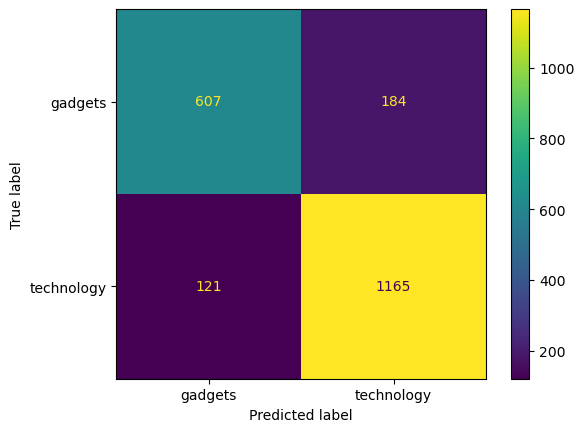

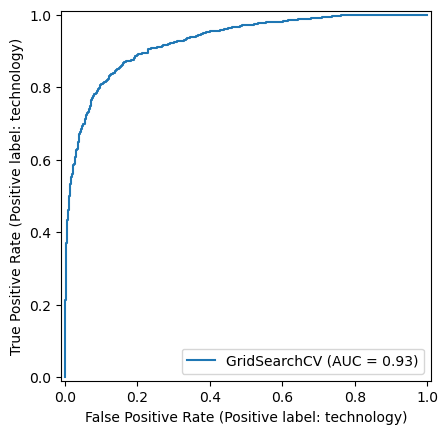

In [403]:
ConfusionMatrixDisplay.from_estimator(gs_nb,X_test,y_test);
RocCurveDisplay.from_estimator(gs_nb,X_test,y_test);

The Naive Bayes model achieved an overall accuracy of 85%, showing solid performance for both "technology" and "gadgets" categories. The model's precision for gadgets was 83%, with a recall of 77%, leading to an F1-score of 0.80. For technology posts, it had a precision of 86% and a recall of 91%, resulting in a strong F1-score of 0.88. The confusion matrix reveals that 607 gadget posts were correctly classified, while 184 were misclassified as technology, and 1,165 technology posts were correctly identified, with 121 misclassified as gadgets. The model's ROC curve, with an AUC of 0.93, indicates strong performance in distinguishing between the two categories.

In [405]:
# Combine all the results into a DataFrame
metrics_comparison = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Testing Accuracy', 'Specificity', 'Recall', 'F1-score Technology', 'F1-score Gadgets'],
    ' Logistic Regression with Count Vectorizer': [logr_train_accuracy, logr_test_accuracy, round(logr_spec, 2), round(logr_recall, 2), round(logr_f1_tech, 2), round(logr_f1_gad, 2)],
    ' KNN with TF-IDF Vectorization': [knn_train_accuracy, knn_test_accuracy,  round(knn_spec, 2), round(knn_recall, 2),  round(knn_f1_tech, 2), round(knn_f1_gad, 2)],
    'Naive Bayes with TF-IDF Vectorizer': [nb_train_accuracy, nb_test_accuracy, round(nb_spec, 2), round(nb_recall, 2), round(nb_f1_tech, 2), round(nb_f1_gad, 2)]

})
metrics_comparison_transposed = metrics_comparison.set_index('Metric').T
metrics_comparison_transposed

Metric,Training Accuracy,Testing Accuracy,Specificity,Recall,F1-score Technology,F1-score Gadgets
Logistic Regression with Count Vectorizer,1.00,0.84,0.75,0.89,0.87,0.78
KNN with TF-IDF Vectorization,0.88,0.84,0.83,0.85,0.87,0.80
Naive Bayes with TF-IDF Vectorizer,0.90,0.85,0.77,0.91,0.88,0.80


Based on the results of the comparison across multiple performance metrics, I would recommend Naive Bayes as the overall best model for your classification task. 

- Balanced Performance:
Naive Bayes has consistently high scores across key metrics like F1 score for technology (0.88), precision (0.86), and recall (0.91). These metrics indicate that the model is strong at both identifying relevant posts (high recall) and minimizing false positives (high precision).
- Higher Recall:
Naive Bayes outperforms Logistic Regression slightly in recall (0.91 vs. 0.89), meaning it is better at identifying true positives—especially important if you want to capture as many relevant posts as possible, particularly in the "technology" category.
- Accuracy:Highest accuracy as compare to other models
- Areas to Improve:Although Naive Bayes is a strong performer, all models struggled somewhat with identifying "gadgets" posts (evidenced by the lower F1 scores for gadgets). 

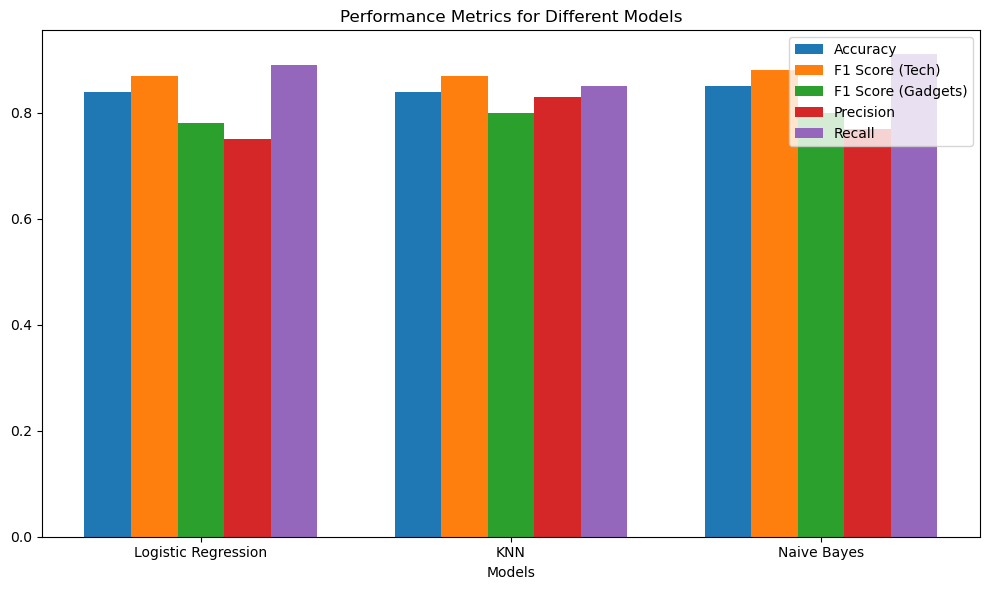

In [407]:
#comparision of models on performance metrices
models = ['Logistic Regression', 'KNN', 'Naive Bayes']

#  performance data:
accuracy = [0.84, 0.84, 0.85]
f1_tech = [0.87, 0.87, 0.88]
f1_gadgets = [0.78, 0.80, 0.80]
specificity = [0.75, 0.83, 0.77]
recall = [0.89, 0.85, 0.91]

# Creating a bar chart for the performance metrics
x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
bar1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy')
bar2 = ax.bar(x - width, f1_tech, width, label='F1 Score (Tech)')
bar3 = ax.bar(x, f1_gadgets, width, label='F1 Score (Gadgets)')
bar4 = ax.bar(x + width, specificity, width, label='Precision')
bar5 = ax.bar(x + 2*width, recall, width, label='Recall')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_title('Performance Metrics for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


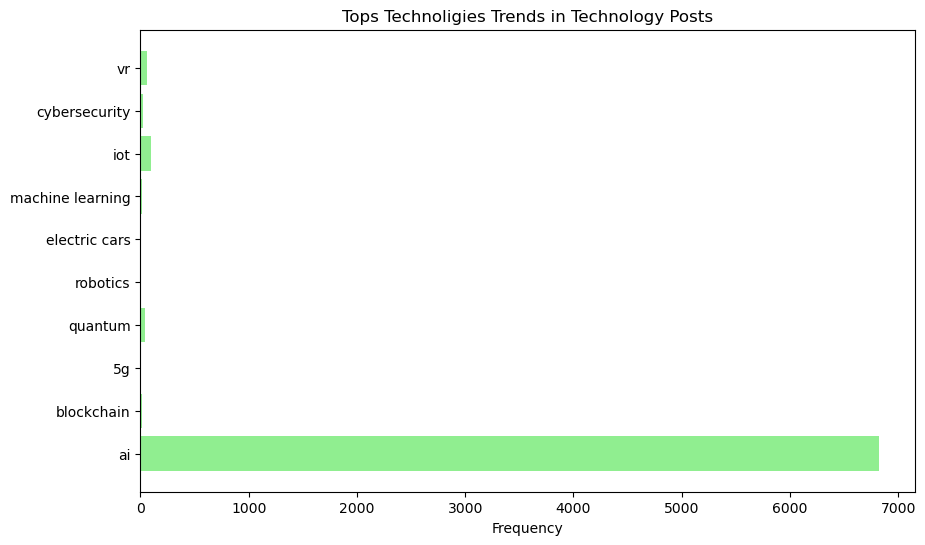

In [408]:
#show top technology treand disscued in technology post
technology_posts = data[data['subreddit'] == 'technology']['processed_text']  # Filter posts labeled as "technology"

#  list of technology-related keywords for the search
keywords = ['ai', 'blockchain', '5g', 'quantum', 'robotics', 'electric cars', 'machine learning', 'iot', 'cybersecurity', 'vr']
keyword_frequencies = {key: 0 for key in keywords}

for post in technology_posts:
    for keyword in keywords:
        keyword_frequencies[keyword] += post.lower().count(keyword)

plt.figure(figsize=(10, 6))
plt.barh(list(keyword_frequencies.keys()), list(keyword_frequencies.values()), color='lightgreen')
plt.xlabel('Frequency')
plt.title('Tops Technoligies Trends in Technology Posts');

 AI is the most frequently discussed topic, followed by  IoT, and other emerging technologies like Quantum and VR.

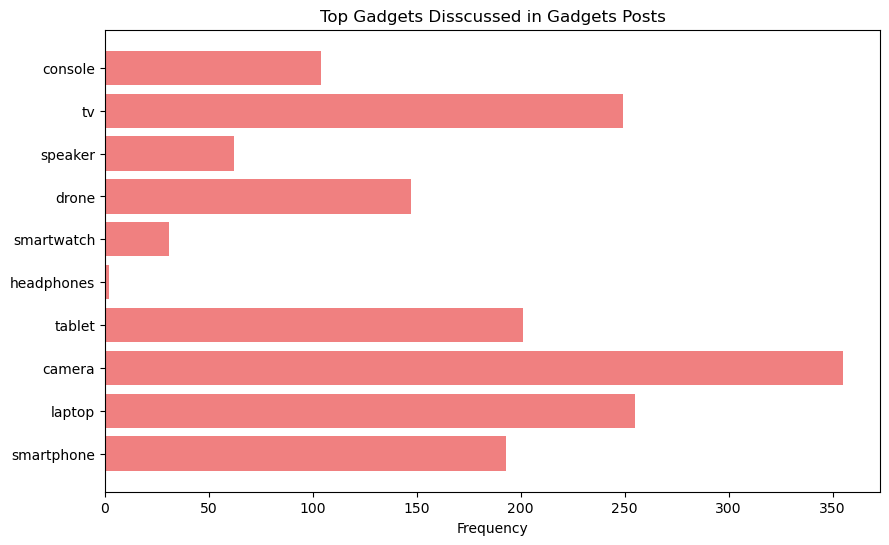

In [410]:
#show top gadgets disscued in technology post
gadget_keywords = ['smartphone', 'laptop', 'camera', 'tablet', 'headphones', 'smartwatch', 'drone', 'speaker', 'tv', 'console']


gadget_keyword_frequencies = {key: 0 for key in gadget_keywords}

gadget_posts = data[data['subreddit'] == 'gadgets']['processed_text']  # Filter posts labeled as "gadgets"



for post in gadget_posts:
    for keyword in gadget_keywords:
        gadget_keyword_frequencies[keyword] += post.lower().count(keyword)



plt.figure(figsize=(10, 6))
plt.barh(list(gadget_keyword_frequencies.keys()), list(gadget_keyword_frequencies.values()), color='lightcoral')
plt.xlabel('Frequency')

plt.title('Top Gadgets Disscussed in Gadgets Posts');


 Camera is the most frequently discussed gaddget, followed by  Tv, and tablet.